In [1]:
import torch
import torch.nn as nn
import joblib
import pandas as pd
import numpy as np
import gzip
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# set device to gpu
device = (
"cuda"
if torch.cuda.is_available()
else "mps"
if torch.backends.mps.is_available()
else "cpu"
)
device

'cuda'

In [2]:
# Load the trained model and scaler

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

def load_model(model_path, input_size, hidden_size=128, num_layers=2):
    model = GRUModel(input_size, hidden_size, num_layers, 1)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

def load_scaler(scaler_path):
    with gzip.open(scaler_path, 'rb') as f:
        scaler = joblib.load(f)
    return scaler

def preprocess_data(new_data, scaler_path, pca_path=None):
    scaler = load_scaler(scaler_path)
    new_data_scaled = scaler.transform(new_data)
    
    if pca_path:
        with gzip.open(pca_path, 'rb') as f:
            pca = joblib.load(f)
        new_data_scaled = pca.transform(new_data_scaled)
        
    return new_data_scaled

def classify_new_data(new_data, model_path, scaler_path, input_size, apply_pca=False):
    model = load_model(model_path, input_size)
    pca_path = scaler_path.replace("scaler", "pca_gru") if apply_pca else None
    preprocessed_data = preprocess_data(new_data, scaler_path, pca_path)
    preprocessed_data_tensor = torch.tensor(preprocessed_data, dtype=torch.float32).unsqueeze(1).to(device)
    with torch.no_grad():
        predictions = model(preprocessed_data_tensor)
    predictions = (predictions > 0.5).float()
    return predictions.cpu().numpy()

Accuracy: 0.9772


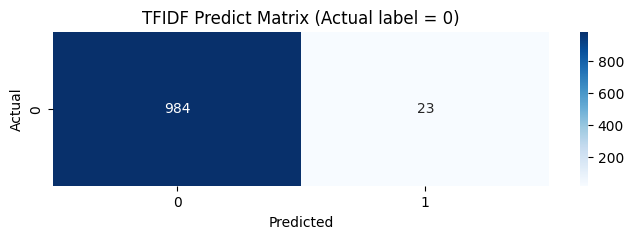

In [3]:
# TFIDF
breeze_tfidf_data_df = pd.read_csv('../Data/breeze_tfidf_vector.csv')
new_data = breeze_tfidf_data_df.iloc[:, 1:-1].values
# assume 0
true_labels = np.zeros(len(new_data))

model_path = '../Data/Model/tfidf_gru_10fold_model.pth.gz'
scaler_path = '../Data/Model/tfidf_10fold_scaler.pkl.gz'
n_components = 800
input_size = n_components

predictions = classify_new_data(new_data, model_path, scaler_path, input_size, apply_pca=True)

# accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

# confusion matrix
cm = confusion_matrix(true_labels, predictions)
cm_actual_0 = cm[0].reshape(1, -1)

# show confusion matrix
plt.figure(figsize=(8, 2))
sns.heatmap(cm_actual_0, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0'])
plt.title('TFIDF Predict Matrix (Actual label = 0)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.6931


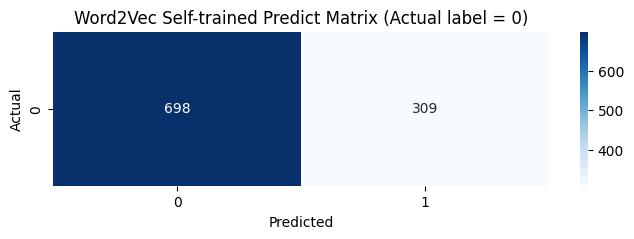

In [4]:
# Word2Vec Self-trained
breeze_word2vec_selftrain_data_df = pd.read_csv('../Data/breeze_word2vec_vector_selftrain.csv')
new_data = breeze_word2vec_selftrain_data_df.iloc[:, 1:-1].values
# assume 0
true_labels = np.zeros(len(new_data))

model_path = '../Data/Model/word2vec_selftrain_gru_10fold_model.pth.gz'
scaler_path = '../Data/Model/word2vec_selftrain_10fold_scaler.pkl.gz'
input_size = new_data.shape[1]

predictions = classify_new_data(new_data, model_path, scaler_path, input_size)

# accuracy
accuracy = accuracy_score(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')

# confusion matrix
cm = confusion_matrix(true_labels, predictions)

cm_actual_0 = cm[0].reshape(1, -1)

# show confusion matrix
plt.figure(figsize=(8, 2))
sns.heatmap(cm_actual_0, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0'])
plt.title('Word2Vec Self-trained Predict Matrix (Actual label = 0)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.7239


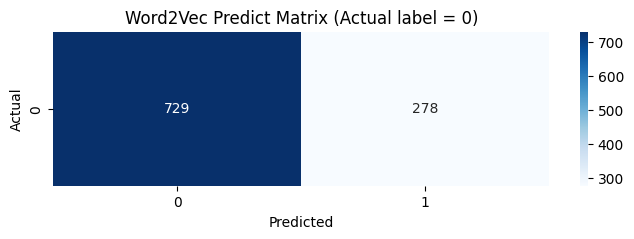

In [5]:
# Word2Vec
breeze_word2vec_data_df = pd.read_csv('../Data/breeze_word2vec_vector.csv')
new_data = breeze_word2vec_data_df.iloc[:, 1:-1].values

true_labels = np.zeros(len(new_data))

model_path = '../Data/Model/word2vec_gru_10fold_model.pth.gz'
scaler_path = '../Data/Model/word2vec_10fold_scaler.pkl.gz'
input_size = new_data.shape[1]

predictions = classify_new_data(new_data, model_path, scaler_path, input_size)

# accuracy
accuracy = accuracy_score(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')

# confusion matrix
cm = confusion_matrix(true_labels, predictions)

cm_actual_0 = cm[0].reshape(1, -1)

# show confusion matrix
plt.figure(figsize=(8, 2))
sns.heatmap(cm_actual_0, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0'])
plt.title('Word2Vec Predict Matrix (Actual label = 0)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.9990


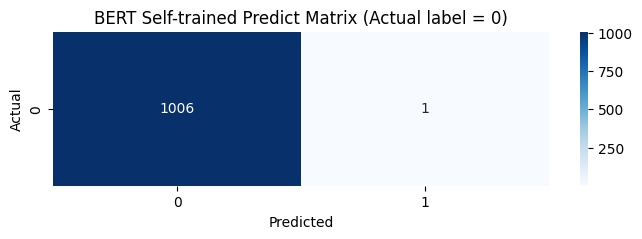

In [18]:
# BERT Self-trained
breeze_bert_selftrain_data_df = pd.read_csv('../Data/breeze_bert_vector_self_train.csv')
new_data = breeze_bert_selftrain_data_df.iloc[:, :-1].values

true_labels = np.zeros(len(new_data))

model_path = '../Data/Model/bert_selftrain_gru_10fold_model.pth.gz'
scaler_path = '../Data/Model/bert_selftrain_10fold_scaler.pkl.gz'
input_size = new_data.shape[1]

predictions = classify_new_data(new_data, model_path, scaler_path, input_size)

# accuracy
accuracy = accuracy_score(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')

# confusion matrix
cm = confusion_matrix(true_labels, predictions)

cm_actual_0 = cm[0].reshape(1, -1)

# show confusion matrix
plt.figure(figsize=(8, 2))
sns.heatmap(cm_actual_0, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0'])
plt.title('BERT Self-trained Predict Matrix (Actual label = 0)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.8272


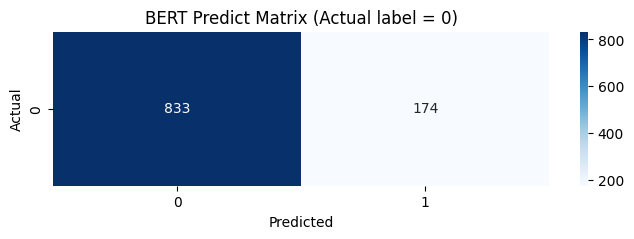

In [9]:
# BERT
breeze_bert_data_df = pd.read_csv('../Data/breeze_bert_vector.csv')
new_data = breeze_bert_data_df.iloc[:, :-1].values

true_labels = np.zeros(len(new_data))

model_path = '../Data/Model/bert_gru_10fold_model.pth.gz'
scaler_path = '../Data/Model/bert_10fold_scaler.pkl.gz'
input_size = new_data.shape[1]

predictions = classify_new_data(new_data, model_path, scaler_path, input_size)

true_labels = np.zeros(len(new_data))

# accuracy
accuracy = accuracy_score(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')

# confusion matrix
cm = confusion_matrix(true_labels, predictions)

cm_actual_0 = cm[0].reshape(1, -1)

# show confusion matrix
plt.figure(figsize=(8, 2))
sns.heatmap(cm_actual_0, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0'])
plt.title('BERT Predict Matrix (Actual label = 0)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()